# Project :  Fraudulent Click Prediction

### Understanding the Business Problem

<a href="https://www.talkingdata.com/">TalkingData</a> is a Chinese big data company, and one of their areas of expertise is mobile advertisements.

In mobile advertisements, **click fraud** is a major source of losses. Click fraud is the practice of repeatedly clicking on an advertisement hosted on a website with the intention of generating revenue for the host website or draining revenue from the advertiser.

In this case, TalkingData happens to be serving the advertisers (their clients). TalkingData cover a whopping **approx. 70% of the active mobile devices in China**, of which 90% are potentially fraudulent (i.e. the user is actually not going to download the app after clicking).

Their current approach to solve this problem is that they've generated a blacklist of IP addresses - those IPs which produce lots of clicks, but never install any apps. Now, they want to try some advanced techniques to predict the probability of a click being genuine/fraud.

In this problem, we will use the features associated with clicks, such as IP address, operating system, device type, time of click etc. to predict the probability of a click being fraud.

They have released <a href="https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection">the problem on Kaggle here.</a>.

In [2]:
#importing the packages
import numpy as np 
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split , KFold , GridSearchCV , cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc 
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

#### save memory when the data is huge

In [3]:
# specify column dtypes to save memory (by default pandas reads some columns as floats)
dtypes = {
        'ip'            : 'uint16',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

In [4]:
# read training_sample.csv for quick testing/debug, else read the full train.csv
testing = True
if testing:
    train_path = "train_sample.csv"
    skiprows = None
    nrows = None
    colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']
else:
    train_path = "train.csv"
    skiprows = range(1, 144903891)
    nrows = 10000000
    colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']

In [5]:
# read training data
train_sample = pd.read_csv(train_path , skiprows = skiprows , nrows = nrows, dtype = dtypes, usecols = colnames)

In [6]:
train_sample.shape

(100000, 7)

In [7]:
print(train_sample.memory_usage())

Index                80
ip               200000
app              200000
device           200000
os               200000
channel          200000
click_time       800000
is_attributed    100000
dtype: int64


In [8]:
# space used by training data
print('Training dataset uses {0} MB'.format(train_sample.memory_usage().sum()/1024**2))

Training dataset uses 1.8120574951171875 MB


In [9]:
train_sample.head(10)

,ip,app,device,os,channel,click_time,is_attributed
0,22004,12,1,13,497,07-11-17 9:30,0
1,40024,25,1,17,259,07-11-17 13:40,0
2,35888,12,1,19,212,07-11-17 18:05,0
3,29048,13,1,13,477,07-11-17 4:58,0
4,2877,12,1,1,178,09-11-17 9:00,0
5,28127,3,1,17,115,09-11-17 1:22,0
6,17059,1,1,17,135,09-11-17 1:17,0
7,55969,9,1,25,442,07-11-17 10:01,0
8,61895,2,2,22,364,08-11-17 9:35,0
9,12564,3,1,19,135,08-11-17 12:35,0


### Exploring the Data - Univariate Analysis

In [10]:
train_sample.describe()

,ip,app,device,os,channel,is_attributed
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,30943.754230,12.04788,21.771250,22.818280,268.832460,0.002270
std,18651.939203,14.94150,259.667767,55.943136,129.724248,0.047591
min,8.000000,1.00000,0.000000,0.000000,3.000000,0.000000
25%,14290.750000,3.00000,1.000000,13.000000,145.000000,0.000000
50%,31117.000000,12.00000,1.000000,18.000000,258.000000,0.000000
75%,46868.250000,15.00000,1.000000,19.000000,379.000000,0.000000
max,65526.000000,551.00000,3867.000000,866.000000,498.000000,1.000000


In [11]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
ip               100000 non-null uint16
app              100000 non-null uint16
device           100000 non-null uint16
os               100000 non-null uint16
channel          100000 non-null uint16
click_time       100000 non-null object
is_attributed    100000 non-null uint8
dtypes: object(1), uint16(5), uint8(1)
memory usage: 1.8+ MB


In [12]:
# Number of unique values in each column
def fraction_unique(x):
    return len(train_sample[x].unique())

number_unique_vals = {x: fraction_unique(x) for x in train_sample.columns}
number_unique_vals

{'ip': 28470,
 'app': 161,
 'device': 100,
 'os': 130,
 'channel': 161,
 'click_time': 4309,
 'is_attributed': 2}

In [13]:
train_sample.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
click_time       object
is_attributed     uint8
dtype: object

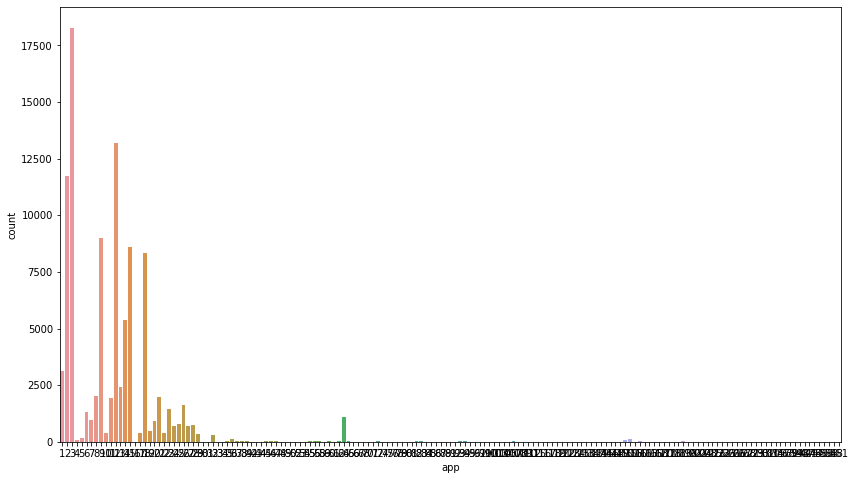

In [14]:
plt.figure(figsize=(14, 8))
sns.countplot(x="app", data=train_sample)

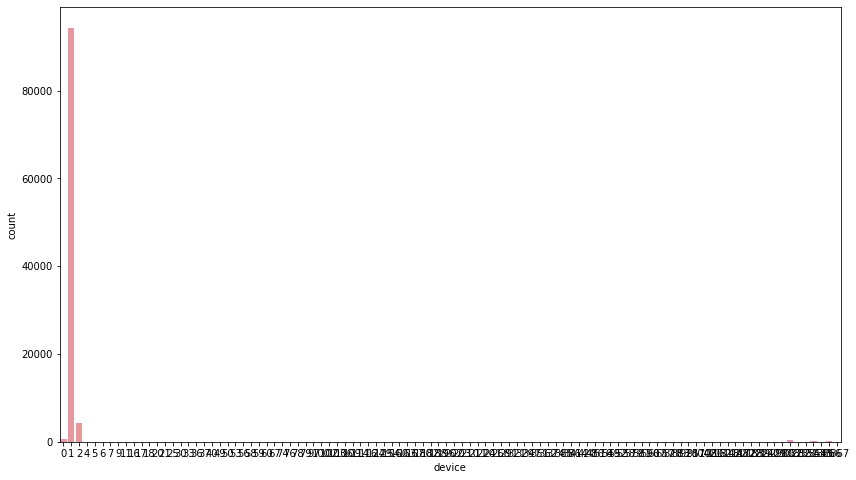

In [15]:
plt.figure(figsize=(14, 8))
sns.countplot(x="device", data=train_sample)

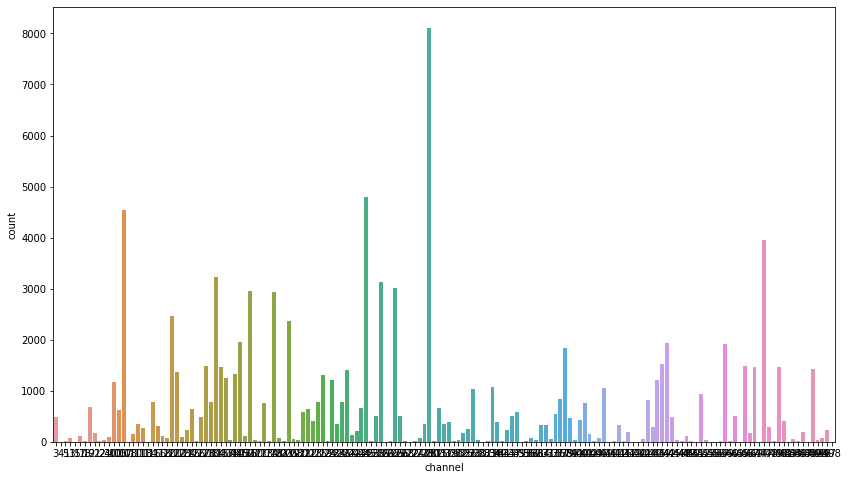

In [16]:
# channel: various channels get clicks in comparable quantities
plt.figure(figsize=(14, 8))
sns.countplot(x="channel", data=train_sample)

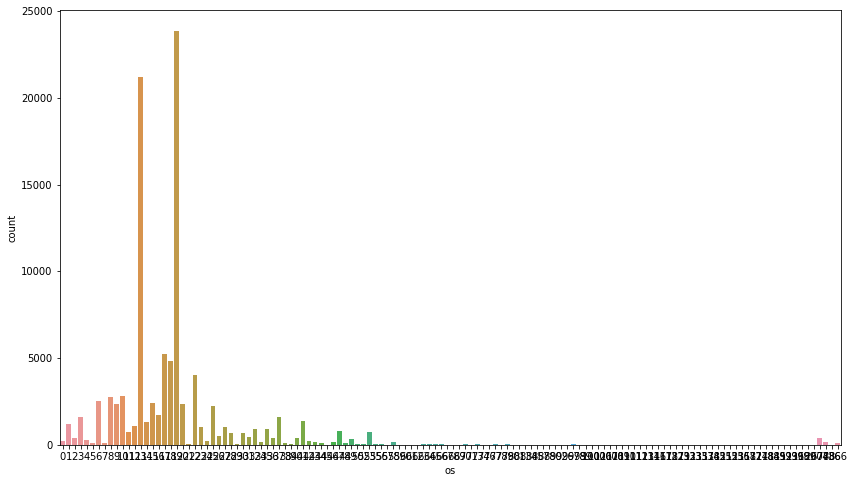

In [17]:
plt.figure(figsize=(14, 8))
sns.countplot(x="os", data=train_sample)

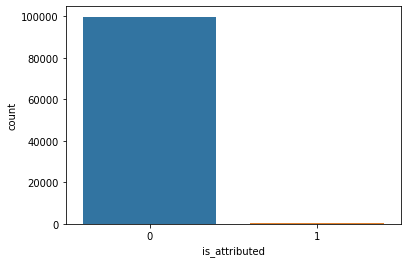

In [18]:
sns.countplot(x = 'is_attributed' , data = train_sample)

In [19]:
100*(train_sample['is_attributed'].astype('object').value_counts()/len(train_sample.index))

0    99.773
1     0.227
Name: is_attributed, dtype: float64

Only 0.2% clicks are fradulent.Which is very huge imbalance classification.

### Exploring the Data - Segmented Univariate Analysis

In [20]:
app_target = train_sample.groupby('app').is_attributed.agg(['mean' , 'count'])
app_target

,mean,count
app,,
1,0.000000,3135
2,0.000000,11737
3,0.000219,18279
4,0.000000,58
5,0.074468,188
6,0.000000,1303
7,0.000000,981
8,0.001996,2004
9,0.000890,8992


This is clearly non-readable, so let's first get rid of all the apps that are very rare (say which comprise of less than 20% clicks) and plot the rest.

In [21]:
frequent_apps = train_sample.groupby('app').size().reset_index(name='count')
frequent_apps = frequent_apps[frequent_apps['count']>frequent_apps['count'].quantile(0.80)]
frequent_apps = frequent_apps.merge(train_sample, on='app', how='inner')
frequent_apps.head()

,app,count,ip,device,os,channel,click_time,is_attributed
0,1,3135,17059,1,17,135,09-11-17 1:17,0
1,1,3135,52432,1,13,115,07-11-17 17:22,0
2,1,3135,23706,1,27,124,07-11-17 9:37,0
3,1,3135,58458,1,19,101,09-11-17 14:27,0
4,1,3135,34067,1,15,134,07-11-17 15:06,0


In [22]:
frequent_apps.shape

(98977, 8)

In [23]:
frequent_apps.isnull().sum()

app              0
count            0
ip               0
device           0
os               0
channel          0
click_time       0
is_attributed    0
dtype: int64

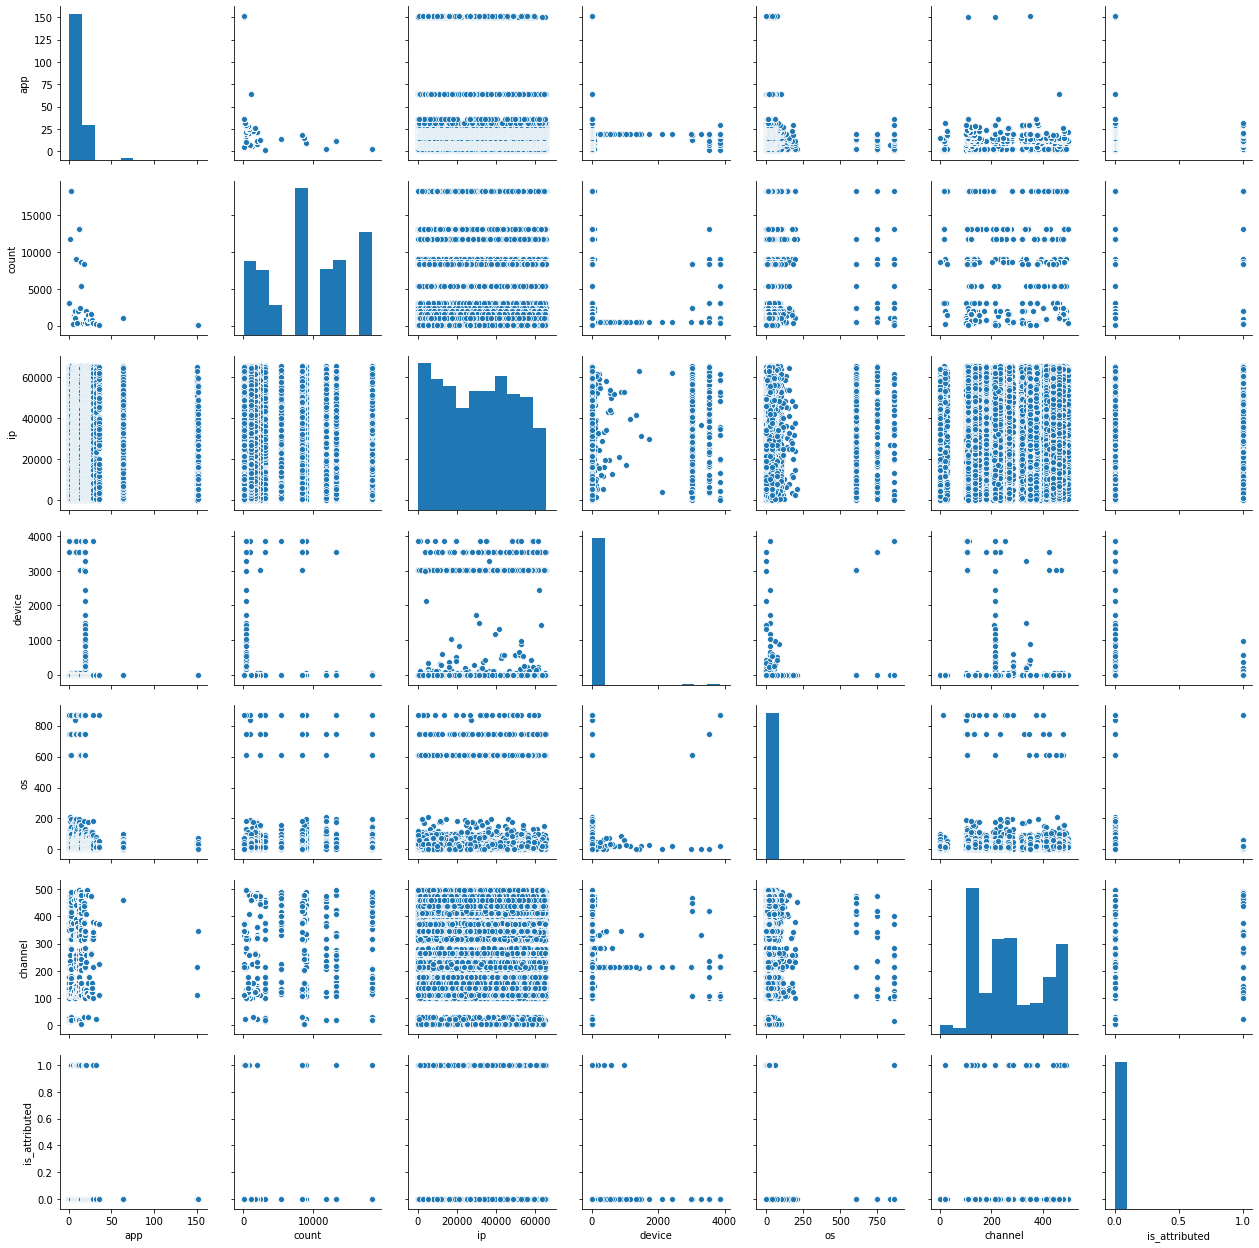

In [24]:
sns.pairplot(frequent_apps)

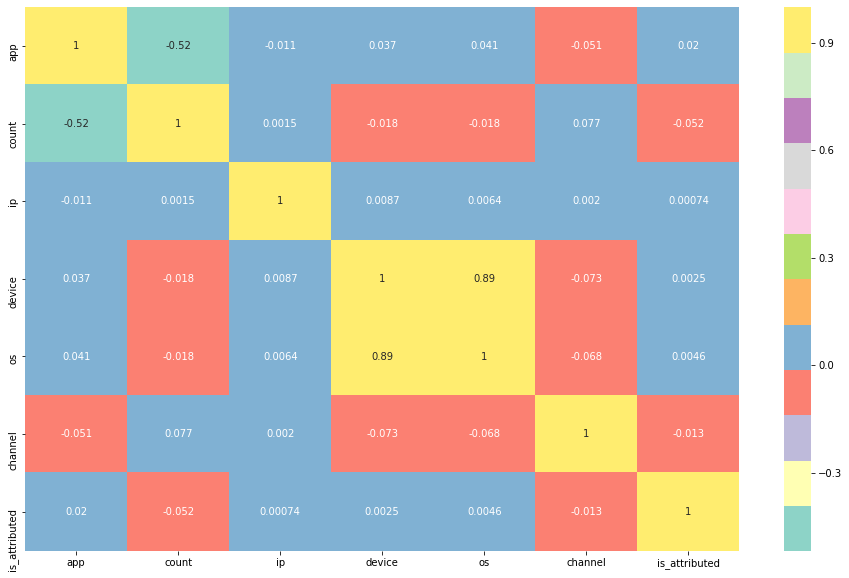

In [25]:
plt.figure(figsize = (16,10)) 
sns.heatmap(frequent_apps.corr() , annot = True , cmap = 'Set3')

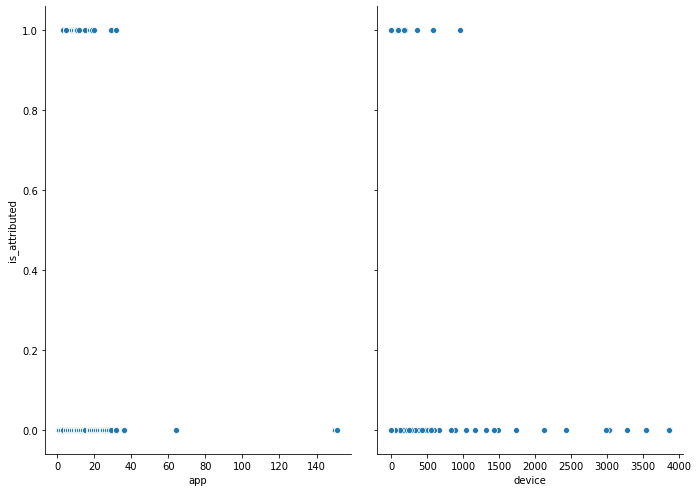

In [26]:
sns.pairplot(frequent_apps , x_vars=['app' , 'device'] , y_vars='is_attributed', size=7 , aspect=0.7 , kind='scatter')

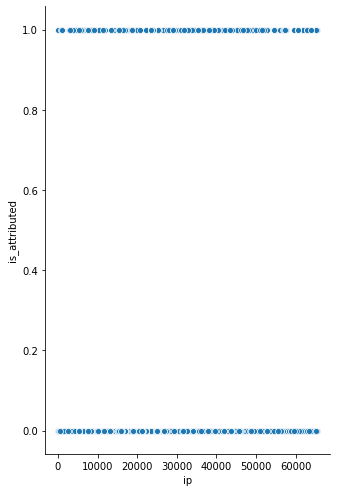

In [27]:
sns.pairplot(frequent_apps , x_vars=['ip'] , y_vars='is_attributed', size=7 , aspect=0.7 , kind='scatter')

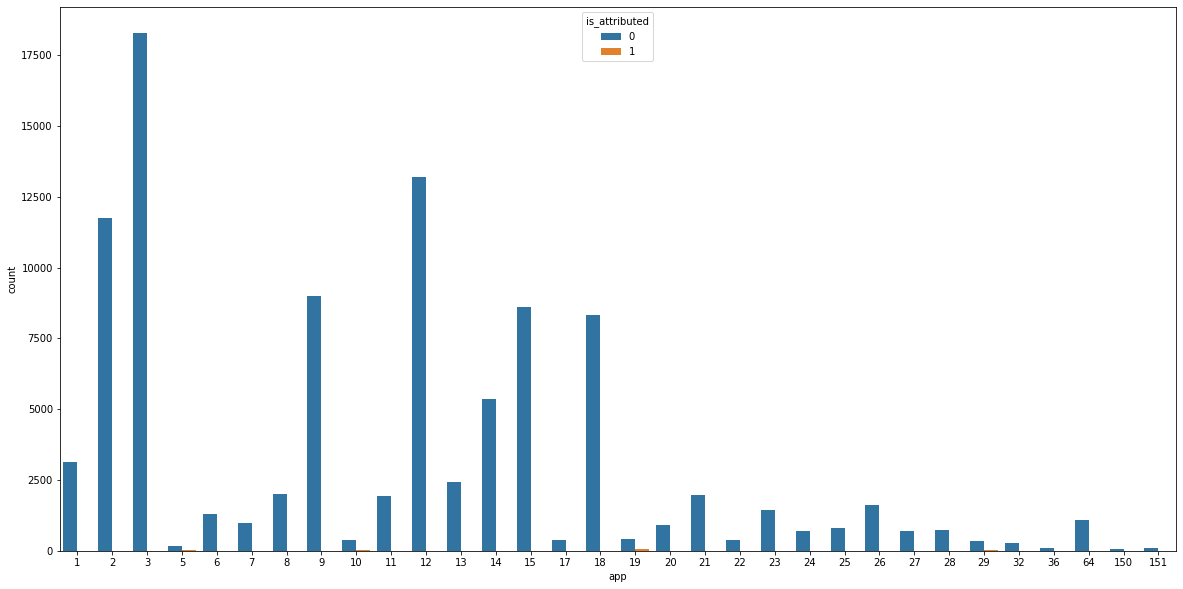

In [28]:
plt.figure(figsize=(20,10))
sns.countplot(x="app", hue="is_attributed", data=frequent_apps);

## Feature Engineering

### Datetime Based Features

In [29]:
# Creating datetime variables
# takes in a df, adds date/time based columns to it, and returns the modified df
def timefeatures(df):
    df['datetime'] = pd.to_datetime(df['click_time'])
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['day_of_year'] = df['datetime'].dt.dayofyear
    df['month'] = df['datetime'].dt.month
    df['hour'] = df['datetime'].dt.hour
    
    return df

In [30]:
# creating new datetime variables and dropping the old ones
train_sample = timefeatures(train_sample)
train_sample.drop(['click_time', 'datetime'], axis=1, inplace=True)
train_sample.head(10)

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,22004,12,1,13,497,0,1,192,7,9
1,40024,25,1,17,259,0,1,192,7,13
2,35888,12,1,19,212,0,1,192,7,18
3,29048,13,1,13,477,0,1,192,7,4
4,2877,12,1,1,178,0,0,254,9,9
5,28127,3,1,17,115,0,0,254,9,1
6,17059,1,1,17,135,0,0,254,9,1
7,55969,9,1,25,442,0,1,192,7,10
8,61895,2,2,22,364,0,4,223,8,9
9,12564,3,1,19,135,0,4,223,8,12


In [31]:
train_sample.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed     uint8
day_of_week       int64
day_of_year       int64
month             int64
hour              int64
dtype: object

In [32]:
# memory used by training data
print('Training dataset uses {0} MB'.format(train_sample.memory_usage().sum()/1024**2))

Training dataset uses 4.1008758544921875 MB


In [33]:
# lets convert the variables back to lower dtype again
int_vars = ['app', 'device', 'os', 'channel', 'day_of_week','day_of_year', 'month', 'hour']
train_sample[int_vars] = train_sample[int_vars].astype('uint16')

In [34]:
train_sample.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed     uint8
day_of_week      uint16
day_of_year      uint16
month            uint16
hour             uint16
dtype: object

In [35]:
print('Training dataset uses {0} MB'.format(train_sample.memory_usage().sum()/1024**2))

Training dataset uses 1.8120574951171875 MB


### IP Grouping Based Features

Let's now create some important features by grouping IP addresses with features such as os, channel, hour, day etc. Also, count of each IP address will also be a feature.

In [36]:
ip_count = train_sample.groupby('ip').size().reset_index(name = 'ip_count').astype('int16')
ip_count.head(30)

,ip,ip_count
0,8,1
1,9,1
2,10,3
3,14,1
4,16,6
5,19,4
6,20,4
7,24,4
8,25,1
9,26,2


Merge this dataframe with the original training dataset. Similarly, we can create combinations of various features such as ip_day_hour (count of ip-day-hour combinations), ip_hour_channel, ip_hour_app, etc. 

In [37]:
# creates groupings of IP addresses with other features and appends the new features to the df
def grouped_features(df):
    # ip_count
    ip_count = df.groupby('ip').size().reset_index(name='ip_count').astype('uint16')
    ip_day_hour = df.groupby(['ip', 'day_of_week', 'hour']).size().reset_index(name='ip_day_hour').astype('uint16')
    ip_hour_channel = df[['ip', 'hour', 'channel']].groupby(['ip', 'hour', 'channel']).size().reset_index(name='ip_hour_channel').astype('uint16')
    ip_hour_os = df.groupby(['ip', 'hour', 'os']).channel.count().reset_index(name='ip_hour_os').astype('uint16')
    ip_hour_app = df.groupby(['ip', 'hour', 'app']).channel.count().reset_index(name='ip_hour_app').astype('uint16')
    ip_hour_device = df.groupby(['ip', 'hour', 'device']).channel.count().reset_index(name='ip_hour_device').astype('uint16')
    
    # merge the new aggregated features with the df
    df = pd.merge(df, ip_count, on='ip', how='left')
    del ip_count
    df = pd.merge(df, ip_day_hour, on=['ip', 'day_of_week', 'hour'], how='left')
    del ip_day_hour
    df = pd.merge(df, ip_hour_channel, on=['ip', 'hour', 'channel'], how='left')
    del ip_hour_channel
    df = pd.merge(df, ip_hour_os, on=['ip', 'hour', 'os'], how='left')
    del ip_hour_os
    df = pd.merge(df, ip_hour_app, on=['ip', 'hour', 'app'], how='left')
    del ip_hour_app
    df = pd.merge(df, ip_hour_device, on=['ip', 'hour', 'device'], how='left')
    del ip_hour_device
    
    return df

In [38]:
train_sample = grouped_features(train_sample)

In [39]:
train_sample.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour,ip_count,ip_day_hour,ip_hour_channel,ip_hour_os,ip_hour_app,ip_hour_device
0,22004,12,1,13,497,0,1,192,7,9,8,1,1,1,1,1
1,40024,25,1,17,259,0,1,192,7,13,149,4,1,1,1,8
2,35888,12,1,19,212,0,1,192,7,18,2,1,1,1,1,1
3,29048,13,1,13,477,0,1,192,7,4,3,1,1,1,1,1
4,2877,12,1,1,178,0,0,254,9,9,4,1,1,1,1,1


In [40]:
train_sample.shape

(100000, 16)

In [41]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 16 columns):
ip                 100000 non-null uint16
app                100000 non-null uint16
device             100000 non-null uint16
os                 100000 non-null uint16
channel            100000 non-null uint16
is_attributed      100000 non-null uint8
day_of_week        100000 non-null uint16
day_of_year        100000 non-null uint16
month              100000 non-null uint16
hour               100000 non-null uint16
ip_count           100000 non-null uint16
ip_day_hour        100000 non-null uint16
ip_hour_channel    100000 non-null uint16
ip_hour_os         100000 non-null uint16
ip_hour_app        100000 non-null uint16
ip_hour_device     100000 non-null uint16
dtypes: uint16(15), uint8(1)
memory usage: 3.7 MB


In [42]:
gc.collect()

8477

## Apply ML Algorithm

In [43]:
X = train_sample.drop('is_attributed', axis=1)
y = train_sample[['is_attributed']]

# split data into train and test/validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(80000, 15)
(80000, 1)
(20000, 15)
(20000, 1)


In [229]:
print(y_train.mean())
print(y_test.mean())

is_attributed    0.002275
dtype: float64
is_attributed    0.00225
dtype: float64


### AdaBoost Regressor

In [230]:
# base estimator
shallow_tree = DecisionTreeClassifier(max_depth=2)

# adaboost with the tree as base estimator
adaboost_model_1 = AdaBoostClassifier(
    base_estimator=shallow_tree,
    n_estimators=600,
    learning_rate=1.5,
    algorithm="SAMME")

In [231]:
adaboost_model_1.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

In [232]:
predictions = adaboost_model_1.predict_proba(X_test)
predictions[:10]

array([[0.54016367, 0.45983633],
       [0.52943472, 0.47056528],
       [0.53867603, 0.46132397],
       [0.52561151, 0.47438849],
       [0.52144896, 0.47855104],
       [0.53147105, 0.46852895],
       [0.52994605, 0.47005395],
       [0.5406561 , 0.4593439 ],
       [0.5277137 , 0.4722863 ],
       [0.51344756, 0.48655244]])

In [233]:
# metrics: AUC
metrics.roc_auc_score(y_test, predictions[:,1])

0.958919791753668

### AdaBoost - Hyperparameter Tuning

In [234]:
param_grid = {
            "base_estimator__max_depth" : range(2 , 20 , 2),
             }

In [235]:
tree = DecisionTreeClassifier()

ABC = AdaBoostClassifier(
    base_estimator=tree,
    algorithm="SAMME")

In [236]:
folds = 5
grid_search_ABC = GridSearchCV(ABC, 
                               cv = folds,
                               param_grid = param_grid, 
                               scoring = 'roc_auc', 
                               return_train_score = True,                         
                               verbose = 1,
                               n_jobs = -1)

In [237]:
grid_search_ABC.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  4.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
   

In [238]:
# cv results
cv_results = pd.DataFrame(grid_search_ABC.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,8.147454,0.038088,0.155582,0.014927,2,{'base_estimator__max_depth': 2},0.920194,0.988326,0.960024,0.942182,...,0.952421,0.022323,1,0.994221,0.992585,0.992891,0.994980,0.995386,0.994012,1.110225e-03
1,14.567405,0.203196,0.163363,0.021763,4,{'base_estimator__max_depth': 4},0.915922,0.968369,0.943893,0.944274,...,0.944281,0.016771,2,0.999899,0.999762,0.999865,0.999869,0.999917,0.999862,5.373891e-05
2,21.289203,0.319608,0.180207,0.022301,6,{'base_estimator__max_depth': 6},0.885776,0.958850,0.904480,0.914100,...,0.915374,0.024039,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
3,26.839820,0.447366,0.211236,0.031935,8,{'base_estimator__max_depth': 8},0.880277,0.949404,0.909647,0.945077,...,0.915753,0.027370,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
4,30.497395,0.300113,0.202581,0.017988,10,{'base_estimator__max_depth': 10},0.854177,0.943547,0.909051,0.910756,...,0.911037,0.031631,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
5,32.160621,0.354966,0.214227,0.013710,12,{'base_estimator__max_depth': 12},0.897666,0.936359,0.903784,0.907032,...,0.902309,0.022240,6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.216188e-16
6,33.380775,0.984227,0.207690,0.047718,14,{'base_estimator__max_depth': 14},0.866477,0.940327,0.905056,0.911002,...,0.900961,0.025369,7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.965068e-17
7,7.966114,10.956844,0.048557,0.035340,16,{'base_estimator__max_depth': 16},0.665523,0.960400,0.733238,0.765907,...,0.770398,0.100390,8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
8,0.944673,0.364525,0.018949,0.005426,18,{'base_estimator__max_depth': 18},0.665664,0.568724,0.637730,0.728503,...,0.655010,0.052222,9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00


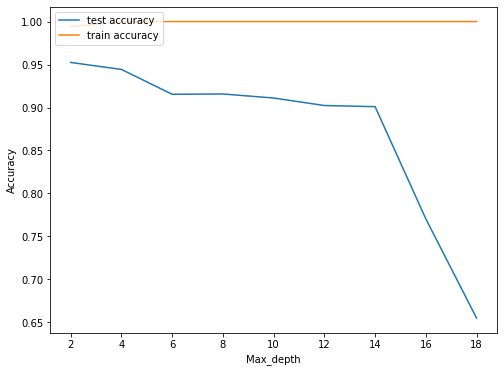

In [239]:
# plotting AUC with hyperparameter combinations
plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_base_estimator__max_depth'], cv_results['mean_test_score'])
plt.plot(cv_results['param_base_estimator__max_depth'], cv_results['mean_train_score'])
plt.xlabel('Max_depth')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
#plt.xscale('log')

In [240]:
grid_search_ABC.best_params_

{'base_estimator__max_depth': 2}

In [241]:
param_grid = {
             "n_estimators" : [200, 400 , 500 , 600 , 800],
             }

In [242]:
folds = 5
grid_search_ABC = GridSearchCV(ABC, 
                               cv = folds,
                               param_grid = param_grid, 
                               scoring = 'roc_auc', 
                               return_train_score = True,                         
                               verbose = 1,
                               n_jobs = -1)

In [243]:
grid_search_ABC.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    4.9s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
   

In [244]:
cv_results = pd.DataFrame(grid_search_ABC.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.678384,0.094144,0.014760,0.005022,200,{'n_estimators': 200},0.638075,0.568567,0.651588,0.661348,...,0.636147,0.034842,4,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,0.674396,0.092023,0.013364,0.001494,400,{'n_estimators': 400},0.679679,0.610297,0.651462,0.647772,...,0.647377,0.022069,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,0.678186,0.090636,0.012765,0.002919,500,{'n_estimators': 500},0.637918,0.568661,0.596095,0.688281,...,0.633157,0.045456,5,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0.686962,0.061775,0.013365,0.003373,600,{'n_estimators': 600},0.651713,0.582613,0.665445,0.688281,...,0.649849,0.035702,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,0.627322,0.062776,0.015159,0.005964,800,{'n_estimators': 800},0.651869,0.568630,0.665289,0.661254,...,0.641659,0.036780,3,1.0,1.0,1.0,1.0,1.0,1.0,0.0


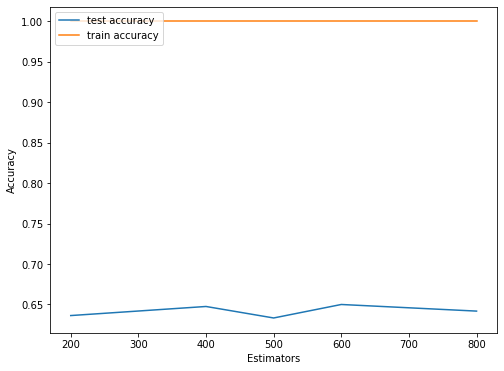

In [245]:
plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_n_estimators'], cv_results['mean_test_score'])
plt.plot(cv_results['param_n_estimators'], cv_results['mean_train_score'])
plt.xlabel('Estimators')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
#plt.xscale('log')

In [246]:
grid_search_ABC.best_params_

{'n_estimators': 600}

HUGE overfiting on the estimator graph.600 estimator will be little bit good.

In [247]:
param_grid = {
             "learning_rate" : [0.001 , 0.01 , 0.1 , 0.6 , 0.8 , 1.0 , 1.3]
             }

In [248]:
folds = 5
grid_search_ABC = GridSearchCV(ABC, 
                               cv = folds,
                               param_grid = param_grid, 
                               scoring = 'roc_auc', 
                               return_train_score = True,                         
                               verbose = 1,
                               n_jobs = -1)

In [249]:
grid_search_ABC.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    6.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
   

In [250]:
cv_results = pd.DataFrame(grid_search_ABC.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.684568,0.062909,0.014760,0.007340,0.001,{'learning_rate': 0.001},0.693505,0.568505,0.596095,0.661316,...,0.633426,0.045166,7,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,0.661430,0.094010,0.020944,0.007436,0.01,{'learning_rate': 0.01},0.679553,0.582707,0.651588,0.674736,...,0.649968,0.035051,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,0.688558,0.093285,0.020545,0.005937,0.1,{'learning_rate': 0.1},0.637855,0.610516,0.665383,0.647678,...,0.644525,0.019615,4,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0.669409,0.092214,0.017354,0.007041,0.6,{'learning_rate': 0.6},0.651838,0.568661,0.679052,0.688312,...,0.649811,0.042559,3,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,0.694342,0.093194,0.012767,0.002631,0.8,{'learning_rate': 0.8},0.665727,0.568630,0.651431,0.661285,...,0.644381,0.038617,5,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5,0.698730,0.094701,0.011769,0.002705,1,{'learning_rate': 1.0},0.665978,0.596502,0.623653,0.647834,...,0.636348,0.024038,6,1.0,1.0,1.0,1.0,1.0,1.0,0.0
6,0.624130,0.083679,0.011768,0.001829,1.3,{'learning_rate': 1.3},0.651901,0.610297,0.665383,0.661473,...,0.650074,0.020378,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0


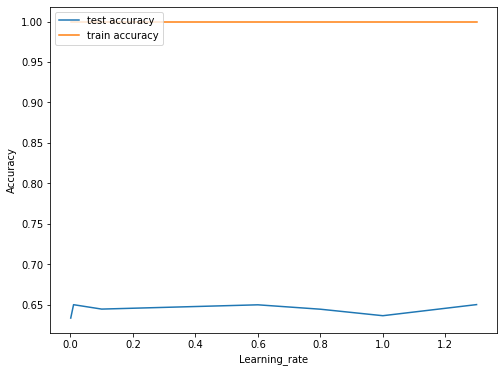

In [251]:
plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_learning_rate'], cv_results['mean_test_score'])
plt.plot(cv_results['param_learning_rate'], cv_results['mean_train_score'])
plt.xlabel('Learning_rate')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')

In [252]:
grid_search_ABC.best_params_

{'learning_rate': 1.3}

In [253]:
tree = DecisionTreeClassifier(max_depth=2)

ABC = AdaBoostClassifier(
    base_estimator = tree,
    learning_rate=0.1,
    n_estimators=600,
    algorithm="SAMME")

ABC.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

In [254]:
predictions = ABC.predict_proba(X_test)
predictions[:10]

array([[0.65697538, 0.34302462],
       [0.65236589, 0.34763411],
       [0.68420007, 0.31579993],
       [0.6180628 , 0.3819372 ],
       [0.6034866 , 0.3965134 ],
       [0.66232658, 0.33767342],
       [0.62480474, 0.37519526],
       [0.63316423, 0.36683577],
       [0.65715211, 0.34284789],
       [0.60695363, 0.39304637]])

In [255]:
metrics.roc_auc_score(y_test, predictions[:, 1])

0.9536785545254601

### Gradient Boosting Classifier

We'll experiment with two main hyperparameters now - ```subsample```. 

By adjusting the learning rate to less than 1, we can regularize the model. A model with higher learning_rate learns fast, but is prone to overfitting; one with a lower learning rate learns slowly, but avoids overfitting.

Also, there's a trade-off between ```learning_rate``` and ```n_estimators``` - the higher the learning rate, the lesser trees the model needs (and thus we usually tune only one of them).

Also, by subsampling (setting ```subsample``` to less than 1), we can have the individual models built on random subsamples of size ```subsample```. That way, each tree will be trained on different subsets and reduce the model's variance.

In [256]:
param_grid = {
              "subsample": [0.3, 0.6, 0.9]
             }

In [257]:
GBC = GradientBoostingClassifier(max_depth=2 , n_estimators = 200)

In [258]:
folds = 5
grid_search_GBC = GridSearchCV(GBC, 
                               cv = folds,
                               param_grid = param_grid, 
                               scoring = 'roc_auc', 
                               return_train_score=True,                         
                               verbose = 1,
                               n_jobs = -1)

grid_search_GBC.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=2,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=200,
                                                  n_iter_no_change=None,
         

In [259]:
cv_results = pd.DataFrame(grid_search_GBC.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,14.802379,0.215488,0.068217,0.017510,0.3,{'subsample': 0.3},0.898426,0.967249,0.862260,0.820824,...,0.861785,0.069956,3,0.904273,0.907404,0.910182,0.845112,0.877548,0.888904,0.024811
1,22.288949,0.538407,0.058642,0.004250,0.6,{'subsample': 0.6},0.873954,0.977106,0.856723,0.876218,...,0.880879,0.052099,2,0.921371,0.942825,0.869141,0.859963,0.869448,0.892550,0.033172
2,24.444745,3.908987,0.048071,0.015544,0.9,{'subsample': 0.9},0.900546,0.973983,0.889629,0.929151,...,0.927495,0.030338,1,0.940888,0.947804,0.939597,0.936763,0.898813,0.932773,0.017364


In [260]:
'''plt.figure(figsize=(16,6))

for n, subsample in enumerate(param_grid['subsample']):   

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')'''

'plt.figure(figsize=(16,6))\n\nfor n, subsample in enumerate(param_grid[\'subsample\']):   \n\n    # subplot 1/n\n    plt.subplot(1,len(param_grid[\'subsample\']), n+1)\n    df = cv_results[cv_results[\'param_subsample\']==subsample]\n\n    plt.plot(df["param_learning_rate"], df["mean_test_score"])\n    plt.plot(df["param_learning_rate"], df["mean_train_score"])\n    plt.xlabel(\'learning_rate\')\n    plt.ylabel(\'AUC\')\n    plt.title("subsample={0}".format(subsample))\n    plt.ylim([0.60, 1])\n    plt.legend([\'test score\', \'train score\'], loc=\'upper left\')\n    plt.xscale(\'log\')'

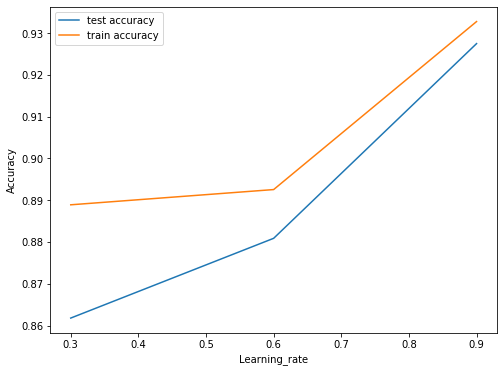

In [261]:
plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_subsample'], cv_results['mean_test_score'])
plt.plot(cv_results['param_subsample'], cv_results['mean_train_score'])
plt.xlabel('Learning_rate')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')

In [262]:
grid_search_GBC.best_params_

{'subsample': 0.9}

In [263]:
GBC = GradientBoostingClassifier(max_depth = 2, learning_rate = 0.1, subsample = 0.6 , n_estimators = 600)
GBC.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=600,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.6, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [264]:
predictions_GBC = GBC.predict_proba(X_test)
predictions_GBC[:10]

array([[9.99566866e-01, 4.33134021e-04],
       [9.99435957e-01, 5.64042673e-04],
       [9.98681005e-01, 1.31899523e-03],
       [9.99601856e-01, 3.98143587e-04],
       [9.98565202e-01, 1.43479759e-03],
       [9.99601856e-01, 3.98143587e-04],
       [9.99112130e-01, 8.87870072e-04],
       [9.99566866e-01, 4.33134021e-04],
       [9.99601856e-01, 3.98143587e-04],
       [9.98608179e-01, 1.39182068e-03]])

In [265]:
metrics.roc_auc_score(y_test, predictions_GBC[:, 1])

0.9389309279211561

### XGBoost

In [266]:
XGB = XGBClassifier()
XGB.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [267]:
y_pred_XGB = XGB.predict_proba(X_test)
y_pred_XGB[:10]

array([[9.9987358e-01, 1.2641525e-04],
       [9.9982178e-01, 1.7821064e-04],
       [9.9982059e-01, 1.7938748e-04],
       [9.9934852e-01, 6.5148144e-04],
       [9.9828207e-01, 1.7179046e-03],
       [9.9973428e-01, 2.6569626e-04],
       [9.9960029e-01, 3.9970913e-04],
       [9.9945855e-01, 5.4146402e-04],
       [9.9985319e-01, 1.4680289e-04],
       [9.9726409e-01, 2.7358907e-03]], dtype=float32)

In [268]:
roc = metrics.roc_auc_score(y_test, y_pred_XGB[:, 1])
print("AUC: %.2f%%" % (roc * 100.0))

AUC: 94.83%


Let's do some hyperparemeter tuning

In [269]:
# hyperparameter tuning with XGBoost
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          

In [270]:
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True,
                        n_jobs = -1)      


In [271]:
model_cv.fit(X_train, y_train)  

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.6min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=2, min_child_weight=1,
                                     missing=None, n_estimators=200, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.6],
                         'subsample': [0.3, 0.6, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=

In [272]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,19.183401,0.125239,0.248669,0.001881,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.918889,0.964657,0.956377,0.946641,0.019912,4,0.991408,0.984470,0.985693,0.987190,0.003024
1,21.330572,0.110766,0.242685,0.009007,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.929922,0.975236,0.961802,0.955653,0.019003,1,0.993757,0.985654,0.991805,0.990405,0.003453
2,20.388138,0.259453,0.216007,0.012744,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.925509,0.972230,0.952191,0.949976,0.019138,2,0.993365,0.990569,0.994547,0.992827,0.001668
3,19.138230,0.224445,0.260636,0.019310,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.880720,0.941324,0.921655,0.914566,0.025244,6,0.995705,0.994496,0.995570,0.995257,0.000541
4,21.148283,0.267230,0.261634,0.023352,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.917806,0.964709,0.955273,0.945929,0.020256,5,0.999515,0.997962,0.999264,0.998914,0.000681
5,15.279942,3.925542,0.193606,0.043544,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.925121,0.974316,0.949797,0.949745,0.020084,3,0.999386,0.999025,0.999643,0.999351,0.000254


In [273]:
model_cv.best_params_

{'learning_rate': 0.2, 'subsample': 0.6}

In [274]:
cv_results['param_learning_rate'] = cv_results['param_learning_rate'].astype('float')
cv_results['param_subsample'] = cv_results['param_subsample'].astype('float')
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,19.183401,0.125239,0.248669,0.001881,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.918889,0.964657,0.956377,0.946641,0.019912,4,0.991408,0.984470,0.985693,0.987190,0.003024
1,21.330572,0.110766,0.242685,0.009007,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.929922,0.975236,0.961802,0.955653,0.019003,1,0.993757,0.985654,0.991805,0.990405,0.003453
2,20.388138,0.259453,0.216007,0.012744,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.925509,0.972230,0.952191,0.949976,0.019138,2,0.993365,0.990569,0.994547,0.992827,0.001668
3,19.138230,0.224445,0.260636,0.019310,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.880720,0.941324,0.921655,0.914566,0.025244,6,0.995705,0.994496,0.995570,0.995257,0.000541
4,21.148283,0.267230,0.261634,0.023352,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.917806,0.964709,0.955273,0.945929,0.020256,5,0.999515,0.997962,0.999264,0.998914,0.000681


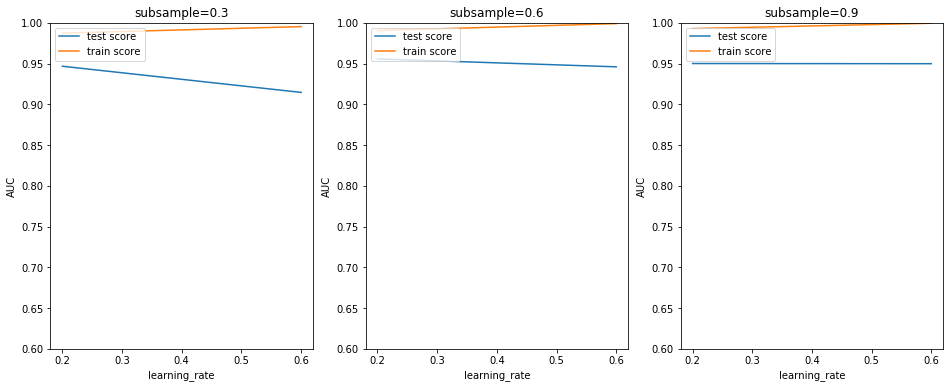

In [275]:
plt.figure(figsize=(16,6))

param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]} 


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    #plt.xscale('log')

In [276]:
params = {'learning_rate': 0.1,
          'max_depth': 5, 
          'n_estimators': 600,
          'subsample': 0.6,
         'objective':'binary:logistic'}

# fit model on training data
model = XGBClassifier(params = params)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic',
              params={'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 600,
                      'objective': 'binary:logistic', 'subsample': 0.6},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [277]:
y_pred = model.predict_proba(X_test)
y_pred[:10]

array([[9.9987358e-01, 1.2641525e-04],
       [9.9982178e-01, 1.7821064e-04],
       [9.9982059e-01, 1.7938748e-04],
       [9.9934852e-01, 6.5148144e-04],
       [9.9828207e-01, 1.7179046e-03],
       [9.9973428e-01, 2.6569626e-04],
       [9.9960029e-01, 3.9970913e-04],
       [9.9945855e-01, 5.4146402e-04],
       [9.9985319e-01, 1.4680289e-04],
       [9.9726409e-01, 2.7358907e-03]], dtype=float32)

In [278]:
auc = sklearn.metrics.roc_auc_score(y_test, y_pred[:, 1])
auc

0.948315376263259

### Feature Importance

Let's look ate the feature importance

In [279]:
importance = dict(zip(X_train.columns, model.feature_importances_))
importance

{'ip': 0.045602705,
 'app': 0.27093488,
 'device': 0.17338613,
 'os': 0.107676595,
 'channel': 0.21930946,
 'day_of_week': 0.016504653,
 'day_of_year': 0.0,
 'month': 0.0,
 'hour': 0.031051902,
 'ip_count': 0.12655772,
 'ip_day_hour': 0.0,
 'ip_hour_channel': 0.0,
 'ip_hour_os': 0.008975947,
 'ip_hour_app': 0.0,
 'ip_hour_device': 0.0}

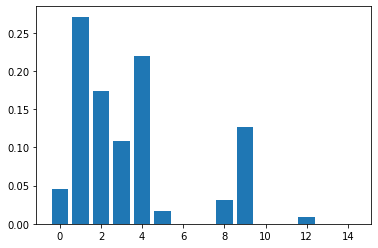

In [280]:
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

In [281]:
train_sample.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour,ip_count,ip_day_hour,ip_hour_channel,ip_hour_os,ip_hour_app,ip_hour_device
0,22004,12,1,13,497,0,1,192,7,9,8,1,1,1,1,1
1,40024,25,1,17,259,0,1,192,7,13,149,4,1,1,1,8
2,35888,12,1,19,212,0,1,192,7,18,2,1,1,1,1,1
3,29048,13,1,13,477,0,1,192,7,4,3,1,1,1,1,1
4,2877,12,1,1,178,0,0,254,9,9,4,1,1,1,1,1


In [282]:
train_sample.shape

(100000, 16)

In [283]:
train_sample.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'is_attributed', 'day_of_week',
       'day_of_year', 'month', 'hour', 'ip_count', 'ip_day_hour',
       'ip_hour_channel', 'ip_hour_os', 'ip_hour_app', 'ip_hour_device'],
      dtype='object')

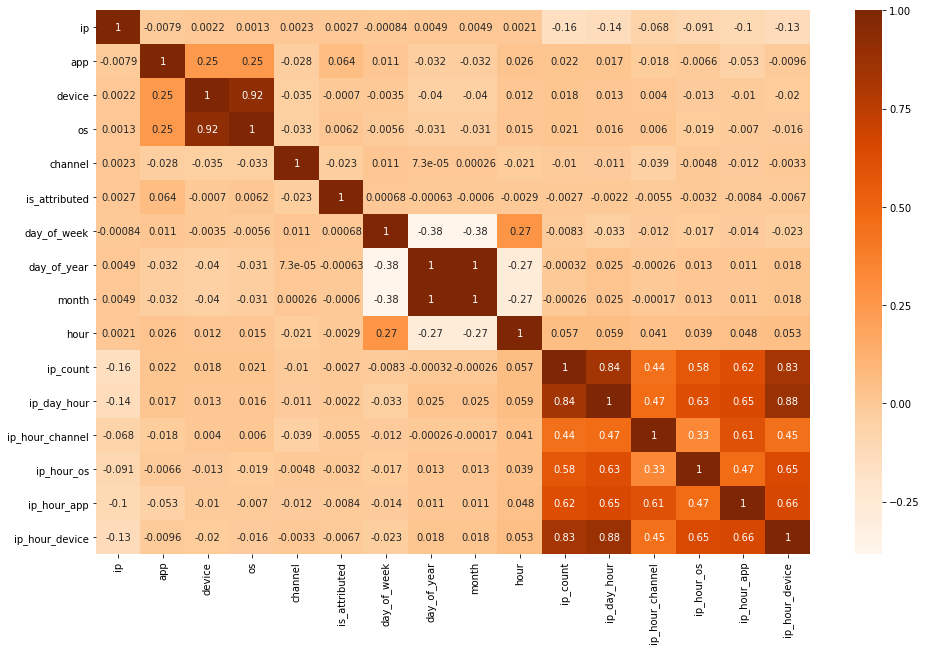

In [284]:
plt.figure(figsize = (16,10)) 
sns.heatmap(train_sample.corr() , annot = True , cmap = 'Oranges')

From the above feature_importance histogram and the correlation matrix is shown that some features are highly correlated each other.
It is also clear that in this dataset there is multi-coliniarity problem.
So we delete those (day_of_year , month , ip_day_hour , ip_hour_channel	, ip_hour_os , ip_hour_app , ip_hour_device)column and check our model again.

## Delete Some columns and test

In [44]:
new_dataset = train_sample
new_dataset.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour,ip_count,ip_day_hour,ip_hour_channel,ip_hour_os,ip_hour_app,ip_hour_device
0,22004,12,1,13,497,0,1,192,7,9,8,1,1,1,1,1
1,40024,25,1,17,259,0,1,192,7,13,149,4,1,1,1,8
2,35888,12,1,19,212,0,1,192,7,18,2,1,1,1,1,1
3,29048,13,1,13,477,0,1,192,7,4,3,1,1,1,1,1
4,2877,12,1,1,178,0,0,254,9,9,4,1,1,1,1,1


In [45]:
X = new_dataset.drop(['is_attributed' , 'day_of_year' , 'month' , 'ip_day_hour' , 'ip_hour_channel' , 'ip_hour_os' , 'ip_hour_app' , 'ip_hour_device'] , axis=1)
y = new_dataset[['is_attributed']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(80000, 8)
(80000, 1)
(20000, 8)
(20000, 1)


## Apply Model

In [46]:
tree = DecisionTreeClassifier(max_depth=2)

adaboost_model_1 = AdaBoostClassifier(
    base_estimator=tree,
    n_estimators=600,
    learning_rate=1.5,
    algorithm="SAMME")

In [47]:
adaboost_model_1.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

In [48]:
predictions = adaboost_model_1.predict_proba(X_test)
predictions[:10]

array([[0.53429595, 0.46570405],
       [0.53595125, 0.46404875],
       [0.53621357, 0.46378643],
       [0.52881417, 0.47118583],
       [0.52428534, 0.47571466],
       [0.52447302, 0.47552698],
       [0.52860943, 0.47139057],
       [0.5424625 , 0.4575375 ],
       [0.52246171, 0.47753829],
       [0.51720034, 0.48279966]])

In [49]:
metrics.roc_auc_score(y_test, predictions[:,1])

0.9658520560149225

In [50]:
tree = DecisionTreeClassifier(max_depth=2)

ABC = AdaBoostClassifier(
    base_estimator=tree,
    learning_rate=0.1,
    n_estimators=600,
    algorithm="SAMME")

ABC.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

In [51]:
predictions = ABC.predict_proba(X_test)
predictions[:10]

array([[0.65538247, 0.34461753],
       [0.65070154, 0.34929846],
       [0.70568216, 0.29431784],
       [0.6332192 , 0.3667808 ],
       [0.60653353, 0.39346647],
       [0.64734185, 0.35265815],
       [0.62335342, 0.37664658],
       [0.63596195, 0.36403805],
       [0.65856886, 0.34143114],
       [0.60882352, 0.39117648]])

In [52]:
metrics.roc_auc_score(y_test, predictions[:,1])

0.9519830730254183

### GBDT

In [53]:
GBC = GradientBoostingClassifier()
GBC.fit(X_train, y_train)
predictions_GBC = GBC.predict_proba(X_test)
metrics.roc_auc_score(y_test, predictions_GBC[:,1])

0.9623970600517832

In [54]:
GBC = GradientBoostingClassifier(max_depth = 2, learning_rate = 0.1 , subsample = 0.6 , n_estimators = 200)
GBC.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.6, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [55]:
predictions_GBC = GBC.predict_proba(X_test)
predictions_GBC[:10]

array([[9.99519064e-01, 4.80936423e-04],
       [9.99476058e-01, 5.23941762e-04],
       [9.98689832e-01, 1.31016799e-03],
       [9.99519064e-01, 4.80936423e-04],
       [9.98689832e-01, 1.31016799e-03],
       [9.99519064e-01, 4.80936423e-04],
       [9.98348748e-01, 1.65125214e-03],
       [9.99519064e-01, 4.80936423e-04],
       [9.99519064e-01, 4.80936423e-04],
       [9.98689832e-01, 1.31016799e-03]])

In [56]:
metrics.roc_auc_score(y_test, predictions_GBC[:,1])

0.9320337425874887

### XGBOOST

In [57]:
params = {'learning_rate': 0.1,
          'max_depth': 2, 
          'n_estimators': 200,
          'subsample': 0.6,
         'objective':'binary:logistic'}

# fit model on training data
model = XGBClassifier(params = params)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic',
              params={'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'subsample': 0.6},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [58]:
y_pred = model.predict_proba(X_test)
y_pred[:10]

array([[9.9985075e-01, 1.4926158e-04],
       [9.9979895e-01, 2.0102716e-04],
       [9.9980748e-01, 1.9253476e-04],
       [9.9938279e-01, 6.1721419e-04],
       [9.9819601e-01, 1.8040008e-03],
       [9.9971277e-01, 2.8725283e-04],
       [9.9956793e-01, 4.3204974e-04],
       [9.9950737e-01, 4.9261062e-04],
       [9.9985260e-01, 1.4741716e-04],
       [9.9680734e-01, 3.1926422e-03]], dtype=float32)

In [59]:
metrics.roc_auc_score(y_test, y_pred[:,1])

0.9470007516913055

In [60]:
importance = dict(zip(X_train.columns, model.feature_importances_))
importance

{'ip': 0.04324373,
 'app': 0.26953062,
 'device': 0.17771086,
 'os': 0.104328826,
 'channel': 0.22581941,
 'day_of_week': 0.017305229,
 'hour': 0.038209107,
 'ip_count': 0.12385225}

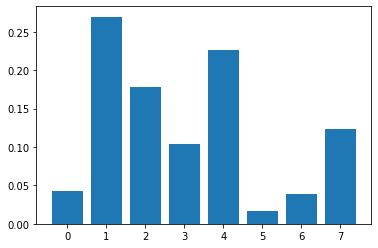

In [61]:
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

In [62]:
X_train.head()

,ip,app,device,os,channel,day_of_week,hour,ip_count
38823,36865,3,1,15,280,4,9,2
78870,11512,12,1,27,259,0,12,81
28393,4574,3,1,9,424,4,12,104
64349,27721,9,1,62,466,0,15,16
23027,13513,2,1,13,237,0,11,3


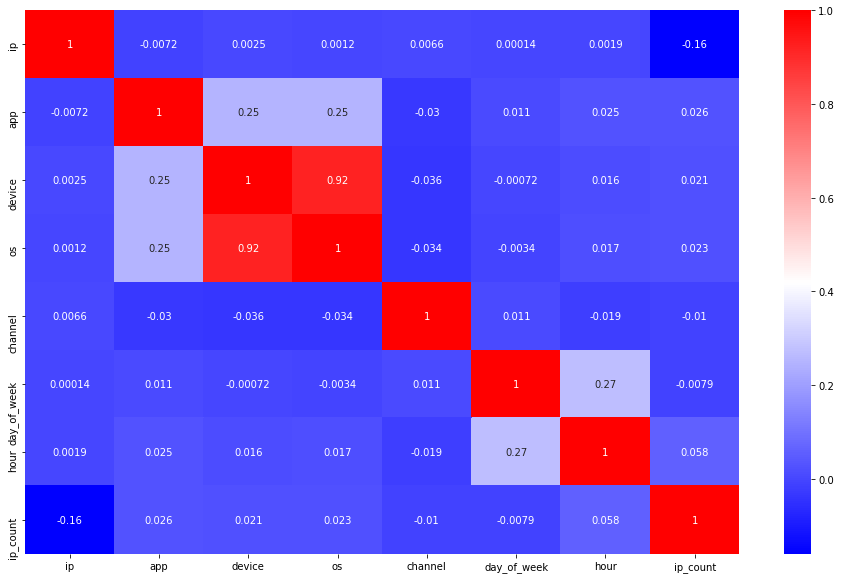

In [63]:
plt.figure(figsize = (16,10)) 
sns.heatmap(X_train.corr() , annot = True , cmap = 'bwr')

### Delete Channel column and check 

In [ ]:
X = new_dataset.drop(['is_attributed' , 'device' , 'day_of_year' , 'month' , 'ip_day_hour' , 'ip_hour_channel' , 'ip_hour_os' , 'ip_hour_app' , 'ip_hour_device'] , axis=1)
y = new_dataset[['is_attributed']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
X_train.columns

In [ ]:
GBC = GradientBoostingClassifier()
GBC.fit(X_train, y_train)
predictions_GBC = GBC.predict_proba(X_test)
metrics.roc_auc_score(y_test, predictions_GBC[:,1])

In [ ]:
GBC = GradientBoostingClassifier(max_depth = 2, learning_rate = 0.1 , subsample = 0.6 , n_estimators = 200)
GBC.fit(X_train, y_train)
predictions_GBC = GBC.predict_proba(X_test)
predictions_GBC[:10]
metrics.roc_auc_score(y_test, predictions_GBC[:,1])

In [ ]:
tree = DecisionTreeClassifier(max_depth=2)

adaboost_model_1 = AdaBoostClassifier(
    base_estimator=tree,
    n_estimators=200,
    learning_rate=0.1,
    algorithm="SAMME")

adaboost_model_1.fit(X_train, y_train)
predictions = adaboost_model_1.predict_proba(X_test)
metrics.roc_auc_score(y_test, predictions[:,1])

In [ ]:
plt.figure(figsize = (16,10)) 
sns.heatmap(X_train.corr() , annot = True , cmap = 'bone')

## Test with real testing data

In [64]:
#read submission file
sample_sub = pd.read_csv('sample_submission.csv')
sample_sub.head(10)

,click_id,is_attributed
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,9,0
9,8,0


In [66]:
#  predict probability of test data
test_final = pd.read_csv('test.csv')
test_final.head()
#test_final1 = pd.read_csv('test.csv')
#test_final1.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [67]:
# # predictions on test data
test_final = timefeatures(test_final)
test_final.head()

,click_id,ip,app,device,os,channel,click_time,datetime,day_of_week,day_of_year,month,hour
0,0,5744,9,1,3,107,2017-11-10 04:00:00,2017-11-10 04:00:00,4,314,11,4
1,1,119901,9,1,3,466,2017-11-10 04:00:00,2017-11-10 04:00:00,4,314,11,4
2,2,72287,21,1,19,128,2017-11-10 04:00:00,2017-11-10 04:00:00,4,314,11,4
3,3,78477,15,1,13,111,2017-11-10 04:00:00,2017-11-10 04:00:00,4,314,11,4
4,4,123080,12,1,13,328,2017-11-10 04:00:00,2017-11-10 04:00:00,4,314,11,4


In [68]:
test_final.drop(['click_time', 'datetime'], axis=1, inplace=True)

In [69]:
test_final.head()

,click_id,ip,app,device,os,channel,day_of_week,day_of_year,month,hour
0,0,5744,9,1,3,107,4,314,11,4
1,1,119901,9,1,3,466,4,314,11,4
2,2,72287,21,1,19,128,4,314,11,4
3,3,78477,15,1,13,111,4,314,11,4
4,4,123080,12,1,13,328,4,314,11,4


In [70]:
X_train.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'day_of_week', 'hour',
       'ip_count'],
      dtype='object')

In [71]:
#test_final[categorical_cols]=test_final[categorical_cols].apply(lambda x: le.fit_transform(x))

In [72]:
test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18790469 entries, 0 to 18790468
Data columns (total 10 columns):
click_id       int64
ip             int64
app            int64
device         int64
os             int64
channel        int64
day_of_week    int64
day_of_year    int64
month          int64
hour           int64
dtypes: int64(10)
memory usage: 1.4 GB


In [73]:
ip_count = test_final.groupby('ip')['channel'].count().reset_index()
ip_count.columns = ['ip', 'ip_count']
ip_count.head()

,ip,ip_count
0,0,2
1,1,1
2,2,5
3,3,64
4,4,6


In [74]:
# merge this with the training data
test_final = pd.merge(test_final, ip_count, on='ip', how='left')

In [75]:
del ip_count

In [76]:
test_final.head()

,click_id,ip,app,device,os,channel,day_of_week,day_of_year,month,hour,ip_count
0,0,5744,9,1,3,107,4,314,11,4,91
1,1,119901,9,1,3,466,4,314,11,4,2083
2,2,72287,21,1,19,128,4,314,11,4,2135
3,3,78477,15,1,13,111,4,314,11,4,1201
4,4,123080,12,1,13,328,4,314,11,4,208


In [77]:
new_test = test_final
new_test.head()

,click_id,ip,app,device,os,channel,day_of_week,day_of_year,month,hour,ip_count
0,0,5744,9,1,3,107,4,314,11,4,91
1,1,119901,9,1,3,466,4,314,11,4,2083
2,2,72287,21,1,19,128,4,314,11,4,2135
3,3,78477,15,1,13,111,4,314,11,4,1201
4,4,123080,12,1,13,328,4,314,11,4,208


In [78]:
test_final.head()

,click_id,ip,app,device,os,channel,day_of_week,day_of_year,month,hour,ip_count
0,0,5744,9,1,3,107,4,314,11,4,91
1,1,119901,9,1,3,466,4,314,11,4,2083
2,2,72287,21,1,19,128,4,314,11,4,2135
3,3,78477,15,1,13,111,4,314,11,4,1201
4,4,123080,12,1,13,328,4,314,11,4,208


In [79]:
new_test = new_test.drop(['click_id' , 'day_of_year' , 'month'] , axis = 1)

In [80]:
X_train.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'day_of_week', 'hour',
       'ip_count'],
      dtype='object')

In [82]:
new_test.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'day_of_week', 'hour',
       'ip_count'],
      dtype='object')

In [83]:
X_train.head()

,ip,app,device,os,channel,day_of_week,hour,ip_count
38823,36865,3,1,15,280,4,9,2
78870,11512,12,1,27,259,0,12,81
28393,4574,3,1,9,424,4,12,104
64349,27721,9,1,62,466,0,15,16
23027,13513,2,1,13,237,0,11,3


In [84]:
new_test.head()

,ip,app,device,os,channel,day_of_week,hour,ip_count
0,5744,9,1,3,107,4,4,91
1,119901,9,1,3,466,4,4,2083
2,72287,21,1,19,128,4,4,2135
3,78477,15,1,13,111,4,4,1201
4,123080,12,1,13,328,4,4,208


In [85]:
test_final.head()

,click_id,ip,app,device,os,channel,day_of_week,day_of_year,month,hour,ip_count
0,0,5744,9,1,3,107,4,314,11,4,91
1,1,119901,9,1,3,466,4,314,11,4,2083
2,2,72287,21,1,19,128,4,314,11,4,2135
3,3,78477,15,1,13,111,4,314,11,4,1201
4,4,123080,12,1,13,328,4,314,11,4,208


In [86]:
print(X_train.shape)
print(new_test.shape)

(80000, 8)
(18790469, 8)


In [88]:
y_pred_test = adaboost_model_1.predict_proba(new_test)
y_pred_test[:10]

array([[0.53023818, 0.46976182],
       [0.53045808, 0.46954192],
       [0.51912602, 0.48087398],
       [0.52134216, 0.47865784],
       [0.53106984, 0.46893016],
       [0.51979865, 0.48020135],
       [0.52825902, 0.47174098],
       [0.52322636, 0.47677364],
       [0.52371173, 0.47628827],
       [0.52832172, 0.47167828]])

In [92]:
sub = pd.DataFrame()
sub['click_id'] = test_final['click_id']
sub['is_attributed'] = y_pred_test[:, 1]
sub.head()

,click_id,is_attributed
0,0,0.469762
1,1,0.469542
2,2,0.480874
3,3,0.478658
4,4,0.468930


In [99]:
sub.to_csv('limon01.csv', float_format='%.8f', index=False)

In [101]:
l = pd.read_csv('limon01.csv')
l.head()

,click_id,is_attributed
0,0,0.469762
1,1,0.469542
2,2,0.480874
3,3,0.478658
4,4,0.468930
